In [1]:
import numpy as np
import random
import seaborn as sns
import scipy.stats as stats
import pandas as pd

### This script simulates the effects of sex-specific stabilizing selection acting on a trait.

First define the individual class. An instance of this class represents an individual in the simulation. Each inidivual has a genotype and sex from which a phenotype and fitness can be calculated. 

The genotype of each individual is diploid and consists of three loci: a locus which affects phenotype in both sexes, a locus which affects phenotype only in males and another which only affects phenotype in females.

Phenotype consists of additive contributions of genotype along with noise.

Fitness is gaussian function of phenotype and represents the probability of an individual surviving to reproduce.

This model allows sex-specific selection coefficients (which factor into the phenotype -> fitness function)


In [162]:
class Indiv:
    
    # allows for the genotype to be given as an argument
    # or a random genotype can be initialized
    def __init__(self, sex, sm, sf, geno = None):
        self.sex = sex
        # init genotype
        if geno == None:
            chr1 = [np.random.normal() for i in range(3)]
            chr2 = [np.random.normal() for i in range(3)]
            self.genotype = [chr1, chr2]
        else:
            self.genotype = geno
            
        self.phenotype = self.calc_pheno()
        self.fitness = self.calc_fitness(sm, sf)
    # calculate phenotype from genotype
    def calc_pheno(self):
    # add scaling factor to the genotype. at this point
    # scale by the total number of loci
        if self.sex == 'm':
            phenotype = 0
            phenotype += (self.genotype[0][0] + self.genotype[1][0])
            # now looking at male specific loci
            phenotype += (self.genotype[0][2] + self.genotype[1][2])
            
            phenotype += np.random.normal()
            #self.phenotype = phenotype
        elif self.sex == 'f':
            phenotype = 0
            # first nloci include shared and female-specific loci
            for i in range(2):
                phenotype += (self.genotype[0][i] + self.genotype[1][i])
            phenotype += np.random.normal()
            #self.phenotype = phenotype
        return(phenotype)
    # calculate fitness from phenotype
    def calc_fitness(self, sm , sf):
        if self.sex == 'm':
            fitness = np.exp((-sm*self.phenotype**2))
        elif self.sex == 'f':
            # stronger selection in females
            fitness = np.exp((-sf*self.phenotype**2))
        return(fitness)
    # mutate function 
    def mutate(self):
        mu = 5e-3
        for i in range(2):
            for j in range(len(self.genotype[0])):
                rand = np.random.uniform(0,1)
                if rand <= mu:
                    # flip genotype
                    self.genotype[i][j] += np.random.normal()
        return(self)
    def select(self):
        rand = np.random.uniform(0,1)
        if rand <= self.fitness:
            # person lives
            return(1)
        else:
            # person dies
            return(0)




### Functions that define mating between two individuals. 

In [163]:
def have1kid(indA, indB, sm, sf):
    
    sex = np.random.choice(['m','f'])
    #kid = Indiv(sex, sm, sf)
    
    chr1 = [np.random.choice([indA.genotype[0][i], indA.genotype[1][i]]) for i in range(len(indA.genotype[0]))]
    chr2 = [np.random.choice([indB.genotype[0][i], indB.genotype[1][i]]) for i in range(len(indB.genotype[0]))]
    genotype = [chr1, chr2]
    kid = Indiv(sex, sm, sf, geno = genotype)
    return(kid)
def mate(indA, indB , nkids, sm, sf):
    
    out = [have1kid(indA, indB, sm, sf) for i in range(nkids)]
    return(out)


Functions to extract phenotype and genotypic variance from a population list

In [164]:
def extract_phenovar(pop):
    pheno_dist = [i.phenotype for i in pop]
    return(np.var(pheno_dist))

In [165]:
def extract_genovar(pop):

    geno_tot = [(i.genotype[0][0] + i.genotype[1][0]) for i in pop]
    return(np.var(geno_tot))


### This is the main function which runs a single simulation. 

The arguments are as follows: "ngen" is the number of generations, "init_pop" is the initial population size, "nmate_pairs" is the number of mating pairs selected (with replacement) from the population, "noffsp" is the number of offspring each mating pair has, "sm" and "sf" are essentially the selection coefficients in males and females with larger values indicating stronger stabilizing selection

In [166]:
def run1sim(ngen, init_pop, nmate_pairs, noffsp, sm, sf):

    for j in range(ngen+1):
        # initialize population
        if j == 0:
            popM = [Indiv('m', sm, sf) for i in range(int(init_pop/2))]
            popF = [Indiv('f', sm, sf) for i in range(int(init_pop/2))]
             
            pheno_initM = extract_phenovar(popM)
            pheno_initF = extract_phenovar(popF)
            # MAF and pheno dataframes to return
            maf_out = pd.DataFrame(data = {'MAF': [extract_genovar(popM + popF)], 
                                           'gen': [0]})
            pheno_outM = pd.DataFrame(data = {'Pheno' : [pheno_initM], 'gen' : [0], 'sex' : ['Male']})
            pheno_outF = pd.DataFrame(data = {'Pheno' : [pheno_initF], 'gen' : [0], 'sex' : ['Female']})
            pheno_out = pd.concat([pheno_outM, pheno_outF])
            
        else:
            # run selection and only keep surviving individuals
            popM_sel = [ind for ind in popM if ind.select() == 1]
            popF_sel = [ind for ind in popF if ind.select() == 1]
            # run mutation 
            popM_sel = [ind.mutate() for ind in popM_sel]
            popF_sel = [ind.mutate() for ind in popF_sel]
            

            
            # randomly sample individuals to mate. This also serves to randomize pairs
            popM = random.choices(popM_sel, k = nmate_pairs)
            popF = random.choices(popF_sel, k = nmate_pairs)
            # create new population through mating
            newpop = []
            for i in range(nmate_pairs):
                newpop += mate(popM[i], popF[i], noffsp, sm = sm, sf = sf)
            # split population into males and females
            # simultaneously calculating phenotype and fitness
            popM = []
            popF = []
            for ind in newpop:
                if ind.sex == 'm':
                    popM += [ind]
                elif ind.sex == 'f':
                    popF += [ind]
        # every 10 generations add phenotype and MAF data
        if (j % 10 == 0) & (j != 0):
            maf_2append = pd.DataFrame(data = {'MAF': [extract_genovar(popM + popF)], 
                                           'gen': [j]})
            maf_out = maf_out.append(maf_2append)
            phenoM = extract_phenovar(popM)
            phenoF = extract_phenovar(popF)
            pheno_2appendM = pd.DataFrame(data = {'Pheno' : [phenoM] , 'gen' : [j], 'sex' : ['Male']})
            pheno_2appendF = pd.DataFrame(data = {'Pheno' : [phenoF], 'gen' : [j], 'sex' : ['Female']})
            pheno_2append = pd.concat([pheno_2appendM, pheno_2appendF])
            
            pheno_out = pheno_out.append(pheno_2append)
    return([maf_out, pheno_out])

Now run the simulations and save the results. The first simulation is with identical selection coefficients in both sexes while the seconds simulation has sex-specific selection. The selection is stronger in females (arbitrary).

In [167]:
nsim = 30
maf = pd.DataFrame(data = {'MAF' : [], 'gen' : []})
pheno = pd.DataFrame(data = {'Pheno' : [], 'gen' : [], 'sex' : []})

# sm = 0.01. sf = 0.05
for i in range(nsim):
    print(i)
    sim_res = run1sim(ngen = 2000,
                  init_pop = 500, 
                  nmate_pairs = 100, 
                  noffsp = 5, sm = 0.005, sf = 0.005)
    maf = maf.append(sim_res[0])
    pheno = pheno.append(sim_res[1])
maf.to_csv('../MAF_simulation_eqsel_OO.csv')
pheno.to_csv('../VAR_simulation_eqsel_OO.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [168]:
nsim = 30
maf = pd.DataFrame(data = {'MAF' : [], 'gen' : []})
pheno = pd.DataFrame(data = {'Pheno' : [], 'gen' : [], 'sex' : []})

# sm = 0.01. sf = 0.05
for i in range(nsim):
    print(i)
    sim_res = run1sim(ngen = 2000,
                  init_pop = 500, 
                  nmate_pairs = 100, 
                  noffsp = 5, sm = 0.005, sf = 0.05)
    maf = maf.append(sim_res[0])
    pheno = pheno.append(sim_res[1])
maf.to_csv('../MAF_simulation_sexsel_OO.csv')
pheno.to_csv('../VAR_simulation_sexsel_OO.csv')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Now plot results

In [3]:
pheno_eqsel = pd.read_csv('../simulation/VAR_simulation_eqsel_OO.csv')
pheno_eqsel['selection'] = ['Equal']*pheno_eqsel.shape[0]
pheno_sexsel = pd.read_csv('../simulation/VAR_simulation_sexsel_OO.csv')
pheno_sexsel['selection'] = ['Sex-specific']*pheno_eqsel.shape[0]
pheno = pd.concat([pheno_eqsel, pheno_sexsel])

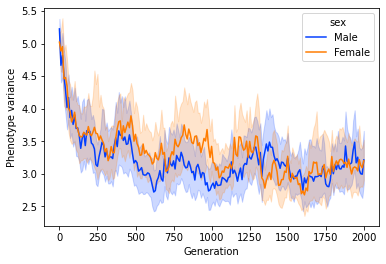

In [4]:
sns.set_palette("bright")
php = sns.lineplot(data= pheno_eqsel, x = 'gen', y = 'Pheno', hue='sex')
php.set(xlabel='Generation', ylabel='Phenotype variance')
php.figure.savefig("../plots_PC/Simulation_pheno_eqsel_OO.pdf")

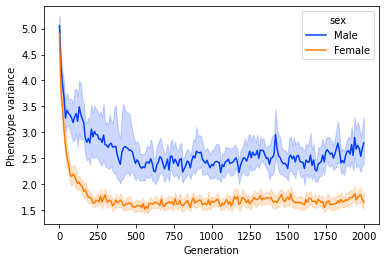

In [6]:
sns.set_palette("bright")
php = sns.lineplot(data= pheno_sexsel, x = 'gen', y = 'Pheno', hue='sex')
php.set(xlabel='Generation', ylabel='Phenotype variance')
php.figure.savefig("../plots_PC/Simulation_pheno_sexsel_OO.pdf")

In [14]:
maf_eqsel = pd.read_csv('../simulation/MAF_simulation_eqsel_OO.csv')
maf_eqsel['selection'] = ['Equal']*maf_eqsel.shape[0]
maf_sexsel = pd.read_csv('../simulation/MAF_simulation_sexsel_OO.csv')
maf_sexsel['selection'] = ['Sex-specific']*maf_eqsel.shape[0]
maf = pd.concat([maf_eqsel, maf_sexsel])

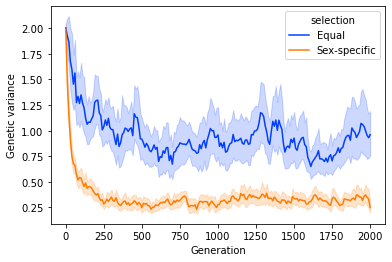

In [17]:
#mafp = sns.FacetGrid(maf, col="Selection", hue="sex")
#mafp.map(sns.lineplot , "gen", "Pheno")
#mafp.set(xlabel='Generation', ylabel='Phenotype variance')
#mafp.add_legend()
sns.set_palette("bright")
mafp = sns.lineplot(data = maf.reset_index(), x = 'gen', y = 'MAF', hue = 'selection')
mafp.set(xlabel='Generation', ylabel='Genetic variance')
mafp.figure.savefig("../plots_PC/Simulation_genovar_OO.pdf")

In [13]:
maf

,Unnamed: 0,MAF,gen,selection
0,0,1.869601,0.0,Equal
1,0,1.856545,10.0,Equal
2,0,1.725189,20.0,Equal
3,0,1.662019,30.0,Equal
4,0,1.568737,40.0,Equal
...,...,...,...,...
6025,0,0.573630,1960.0,Sex-specific
6026,0,0.414087,1970.0,Sex-specific
6027,0,0.278442,1980.0,Sex-specific
6028,0,0.346518,1990.0,Sex-specific
